# 1. Data preprocessing

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
import re
from sklearn.metrics import f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read data
df1 = pd.read_json('../Data/domain1_train_data.json', lines=True)
df2 = pd.read_json('../Data/domain2_train_data.json', lines=True)

# Define Domains
df1['domain'], df2['domain'] = 1, 2

# Split set 1
x1_tr, x_dv = train_test_split(df1, stratify=df1['label'], random_state=0, test_size=0.2)
# Split set 2
x2_1 = df2[df2['label'] == 1].sample(500, random_state=0)
x2_0 = df2[df2['label'] == 0].sample(500, random_state=0)
x2_tr = df2[[i not in list(pd.concat([x2_1, x2_0]).reset_index()['index']) for i in df2.index]].reset_index(drop=True)
x2_dev = pd.concat([x2_1,x2_0]).reset_index(drop=True)

# Train test sets
x_train = pd.concat([x1_tr, x2_tr]).sample(frac=1).reset_index(drop=True)
x_dev_ = pd.concat([x_dv, x2_dev]).sample(frac=1).reset_index(drop=True)

# Transform numbers to strings to treat them as tokens
txt1 = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in x1_tr['text']]
txt2 = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in x2_tr['text']]
aug_txt = [re.sub(',', '', ', '.join([str(x) for x in tok])) for tok in x_train['text']]

# Final train test sets
x_tr_aug, y_train = aug_txt, x_train['label']
x_dev_, y_dev = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in x_dev_['text']], np.array(x_dev_['label'].astype('float32'))

# Print classes proportion
print(round(y_train.value_counts()/len(y_train),2))

label
0    0.81
1    0.19
Name: count, dtype: float64


# 2. Encoding

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Tokens encoding to sparce matrix (Countv)
Cvec = CountVectorizer(ngram_range=(8,9))
x_train_c = Cvec.fit_transform(x_tr_aug)
x_dev_c = Cvec.transform(x_dev_)


# Tokens encoding to sparce matrix (Tfid)
Tvec = TfidfVectorizer()
x_train_t = Tvec.fit_transform(x_tr_aug)
x_dev_t = Tvec.transform(x_dev_)

In [4]:
x_dev_c.shape

(2000, 5154787)

# 3. Logistic model

In [5]:
from sklearn.linear_model import LogisticRegression

# Train models
cl_aug_c = LogisticRegression().fit(x_train_c, y_train)
cl_aug_t = LogisticRegression().fit(x_train_t, y_train)
cl_aug_c_w = LogisticRegression(class_weight="balanced").fit(x_train_c, y_train)
cl_aug_t_w = LogisticRegression(class_weight="balanced").fit(x_train_t, y_train)

In [6]:
# Data augmentation scores
sc_aug_c_tr, sc_aug_c_ts = cl_aug_c.score(x_train_c, y_train), cl_aug_c.score(x_dev_c, y_dev)
sc_aug_t_tr, sc_aug_t_ts = cl_aug_t.score(x_train_t, y_train), cl_aug_t.score(x_dev_t, y_dev)
sc_aug_c_w_tr, sc_aug_c_w_ts = cl_aug_c_w.score(x_train_c, y_train), cl_aug_c_w.score(x_dev_c, y_dev)
sc_aug_t_w_tr, sc_aug_t_w_ts = cl_aug_t_w.score(x_train_t, y_train), cl_aug_t_w.score(x_dev_t, y_dev)
# F1 scores
f1_aug_c_tr, f1_aug_c_ts = f1_score(y_train, cl_aug_c.predict(x_train_c)), f1_score(y_dev, cl_aug_c.predict(x_dev_c))
f1_aug_t_tr, f1_aug_t_ts = f1_score(y_train, cl_aug_t.predict(x_train_t)), f1_score(y_dev, cl_aug_t.predict(x_dev_t))
f1_aug_c_w_tr, f1_aug_c_w_ts = f1_score(y_train, cl_aug_c_w.predict(x_train_c)), f1_score(y_dev, cl_aug_c_w.predict(x_dev_c))
f1_aug_t_w_tr, f1_aug_t_w_ts = f1_score(y_train, cl_aug_t_w.predict(x_train_t)), f1_score(y_dev, cl_aug_t_w.predict(x_dev_t))

# Print scores
print(f'Model -DA using  Cvec:\t\ttr_acc: {sc_aug_c_tr:.3f}\tval_acc: {sc_aug_c_ts:.3f}\ttr_F1" {f1_aug_c_tr:.3f}\tts_F1" {f1_aug_c_ts:.3f}')
print(f'Model -DA using  Cvec-w:\ttr_acc: {sc_aug_c_w_tr:.3f}\tval_acc: {sc_aug_c_w_ts:.3f}\ttr_F1" {f1_aug_c_w_tr:.3f}\tts_F1" {f1_aug_c_w_ts:.3f}')
print()
print(f'Model -DA using  Tvec:\t\ttr_acc: {sc_aug_t_tr:.3f}\tval_acc: {f1_aug_t_tr:.3f}\ttr_F1" {f1_aug_c_w_tr:.3f}\tts_F1" {f1_aug_t_ts:.3f}')
print(f'Model -DA using  Tvec-w:\ttr_acc: {sc_aug_t_w_tr:.3f}\tval_acc: {sc_aug_t_w_ts:.3f}\ttr_F1" {f1_aug_t_w_tr:.3f}\tts_F1" {f1_aug_t_w_ts:.3f}')

Model -DA using  Cvec:		tr_acc: 0.999	val_acc: 0.495	tr_F1" 0.997	ts_F1" 0.000
Model -DA using  Cvec-w:	tr_acc: 1.000	val_acc: 0.933	tr_F1" 1.000	ts_F1" 0.933

Model -DA using  Tvec:		tr_acc: 0.892	val_acc: 0.639	tr_F1" 1.000	ts_F1" 0.420
Model -DA using  Tvec-w:	tr_acc: 0.895	val_acc: 0.597	tr_F1" 0.772	ts_F1" 0.602


In [7]:
print("Best Model:")
print(f'Model -DA using  Cvec-w:\ttr_acc: {sc_aug_c_w_tr:.3f}\tval_acc: {sc_aug_c_w_ts:.3f}\
      tr_F1" {f1_aug_c_w_tr:.3f}\tts_F1" {f1_aug_c_w_ts:.3f}\
      ROC_AUC: {roc_auc_score(y_dev, cl_aug_c_w.predict(x_dev_c))}')

Best Model:
Model -DA using  Cvec-w:	tr_acc: 1.000	val_acc: 0.933      tr_F1" 1.000	ts_F1" 0.933      ROC_AUC: 0.933


### Hyperparameter Tunning

In [39]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
parameters ={
    'max_iter' : range(100, 500, 100),
    'C' : np.arange(0, 1, 0.1),
}

grid = GridSearchCV(estimator = LogisticRegression(class_weight="balanced"),
                                param_grid  = parameters,
                                #    param_distributions = parameters,
                                #    n_iter = 2,
                                   scoring = 'roc_auc',
                                   verbose = 3, 
                                   cv = 2
                                #    random_state = 1,
                                  )

grid.fit(x_train_c, y_train)

Fitting 2 folds for each of 40 candidates, totalling 80 fits
[CV 1/2] END .................C=0.0, max_iter=100;, score=nan total time=   0.0s
[CV 2/2] END .................C=0.0, max_iter=100;, score=nan total time=   0.0s
[CV 1/2] END .................C=0.0, max_iter=200;, score=nan total time=   0.0s
[CV 2/2] END .................C=0.0, max_iter=200;, score=nan total time=   0.0s
[CV 1/2] END .................C=0.0, max_iter=300;, score=nan total time=   0.0s
[CV 2/2] END .................C=0.0, max_iter=300;, score=nan total time=   0.0s
[CV 1/2] END .................C=0.0, max_iter=400;, score=nan total time=   0.0s
[CV 2/2] END .................C=0.0, max_iter=400;, score=nan total time=   0.0s
[CV 1/2] END ...............C=0.1, max_iter=100;, score=0.941 total time=   7.6s
[CV 2/2] END ...............C=0.1, max_iter=100;, score=0.946 total time=   8.2s
[CV 1/2] END ...............C=0.1, max_iter=200;, score=0.941 total time=   6.9s
[CV 2/2] END ...............C=0.1, max_iter=200;

GridSearchCV(cv=2, estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'max_iter': range(100, 500, 100)},
             scoring='roc_auc', verbose=3)

In [40]:
grid.score(x_train_c, y_train)

0.9999977435897436

In [42]:
print("Best Model:")
print(f'Grid search (Without baseline paramenters):\
      val_acc: {grid.score(x_dev_c, y_dev):.3f}\
      ts_F1" {f1_score(y_dev, grid.predict(x_dev_c)):.3f}\
      ROC_AUC: {roc_auc_score(y_dev, grid.predict(x_dev_c))}')

Best Model:
Grid search (Without baseline paramenters):      val_acc: 0.921      ts_F1" 0.928      ROC_AUC: 0.9279999999999999


# 4. Predict

In [9]:
test = pd.read_json('../Data/test_data.json', lines=True)['text']
test = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in test]
test_c = Cvec.transform(test)

preds = cl_aug_c_w.predict(test_c)

test_df = pd.DataFrame(columns = ['id', 'value'])
for idx, v in enumerate(preds):
    test_df.loc[idx] = [idx, preds[idx]]
test_df.to_csv('../Data/predictions_lr.csv', index=False)

### Use full dataset

In [10]:
df_full = pd.concat([df1, df2]).sample(frac=1).reset_index(drop=True)
txt_full = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in df_full['text']]
# Full vect
Cvec_f = CountVectorizer(ngram_range=(8,9))
x_full = Cvec_f.fit_transform(txt_full)
y_full = df_full['label']
# Full model
cl_aug_c_w = LogisticRegression(class_weight="balanced").fit(x_full, y_full)

In [11]:
test = pd.read_json('../Data/test_data.json', lines=True)['text']
test = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in test]
test_c = Cvec_f.transform(test)

preds = cl_aug_c_w.predict(test_c)

test_df = pd.DataFrame(columns = ['id', 'value'])
for idx, v in enumerate(preds):
    test_df.loc[idx] = [idx, preds[idx]]
test_df.to_csv('../Data/predictions_lr.csv', index=False)

# 5. Plot results

In [12]:
# Helper function to get model metrics
def max_pr(pr, y):
    l = []
    p, r = [], []
    min = 1
    y_ = pd.Series(y)
    for i in range(1,100):
        # ACC
        acc = sum([0 if p < i/100 else 1 for p in pr[1]] == y)/len(y)
        l.append(acc)
        # Precision
        ind_0 = y_[y_==0].index
        prec = sum([0 if p < i/100 else 1 for p in pr[1][ind_0]] == y_[y_==0])/len(ind_0)
        p.append(prec)
        # Recall
        ind_1 = y_[y_==1].index
        rec = sum([0 if p < i/100 else 1 for p in pr[1][ind_1]] == y_[y_==1])/len(ind_1)
        r.append(rec)
        # Closest point
        if abs((acc-prec)+(acc-rec)+(rec-prec)/3) < min:
            min = abs((acc-prec)+(acc-rec)+(rec-prec)/3)
            ind = i

    print(f'Acc: {l[ind-1]:.3f}, Precision: {p[ind-1]:.3f}, Recall: {r[ind-1]:.3f}, Closest point: {ind-1:.3f}')
    return l, p, r, ind-1

# Helper function to plot model probabilities
def plot_ptobs(p_tr, p_dv, acc, prec, rec):
    # Plot Training probabilities
    fig = plt.figure(figsize=(18, 10))
    fig.suptitle('Probabilities distribution')
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.scatter([i for i in range(len(y_train))], p_tr[0], c=y_train)
    ax1.set_title('Training probabilities')
    ax1.set_xlabel('Observation')
    ax1.set_ylabel('Probability')
    ax1.legend(['Label 1','Label 0'])
    # Plot Test probabilities
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.scatter([i for i in range(len(y_dev))], p_dv[0], c=y_dev)
    ax2.set_title('Dev probabilities')
    ax2.set_xlabel('Observation')
    ax2.set_ylabel('Probability')
    ax2.legend(['Label 1','Label 0'])
    # Plot test thresholds
    ax3 = fig.add_subplot(2, 2, 3) 
    ax3.plot(acc, ls='--')
    ax3.plot(prec)
    ax3.plot(rec)
    ax3.vlines(min, 0, 1, colors='r', ls=':')
    ax3.set_title('Threshold tradeoff')
    ax3.set_xlabel('Threshold')
    ax3.set_ylabel('Probability')
    ax3.legend(['Accuracy','Precision','Recall', 'Threshold'])

    plt.show()

Acc: 0.932, Precision: 0.930, Recall: 0.934, Closest point: 28.000


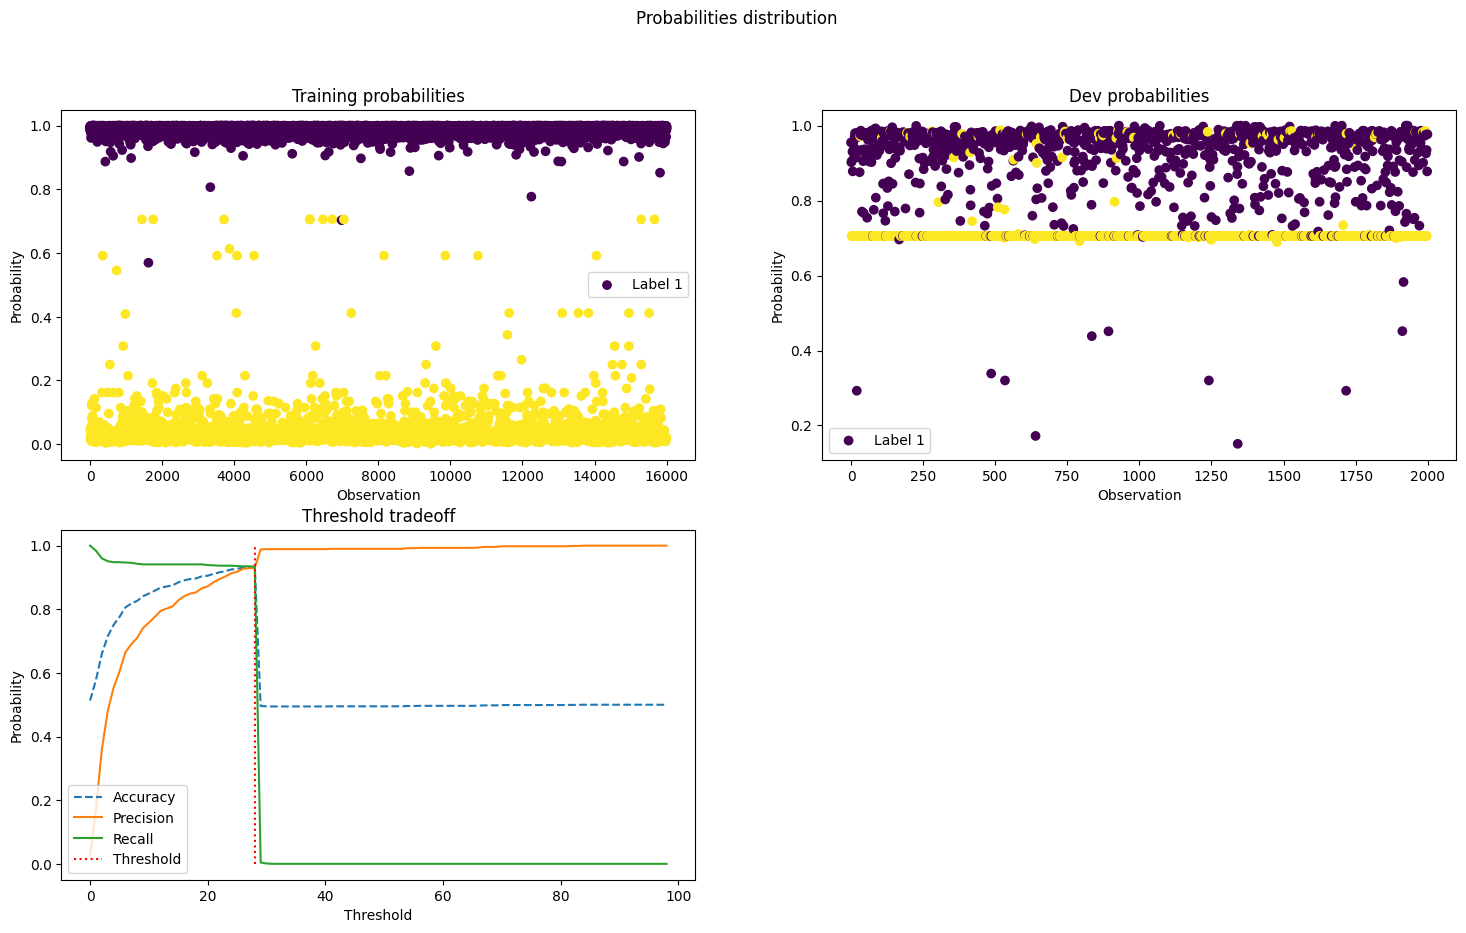

In [13]:
p_tr = cl_aug_c.predict_proba(x_train_c).T
p_dv = cl_aug_c.predict_proba(x_dev_c).T
acc, prec, rec, min = max_pr(p_dv, y_dev)
plot_ptobs(p_tr, p_dv, acc, prec, rec)